In [61]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, plot=True):
    """
    Evaluate regression predictions for IMD rank.
    
    Parameters:
    - y_true: array-like, true IMD ranks
    - y_pred: array-like, predicted IMD ranks
    - plot: bool, whether to show scatter plot of predicted vs actual
    
    Returns:
    - metrics: dictionary with RMSE, MAE, R2, Spearman correlation
    """
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    print("Model evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel("True IMD Rank")
        plt.ylabel("Predicted IMD Rank")
        plt.title("Predicted vs Actual IMD Rank")
        plt.grid(True)
        plt.show()

    return metrics

### Get imd data

In [69]:
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2011)": "LSOA11CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# Build model with one embedding per cluster, per LSOA
### Get data 

In [70]:
avg_embeddings_per_cluster = pd.read_pickle(data_dir +"global_clusters_mean_embeddings.pkl")
# Keep only LSOAs where no cluster embedding is missing
K=5
cluster_cols = [f'cluster_{k}' for k in range(K)]
avg_embeddings_per_cluster = avg_embeddings_per_cluster.dropna(subset=cluster_cols)
# join to imd data
avg_embeddings_per_cluster_with_imd = pd.merge(left=avg_embeddings_per_cluster, right=imd, on="LSOA11CD")

### Run model

Model evaluation metrics:
RMSE: 7006.866
MAE: 5880.516
R2: 0.463
Spearman_rank_corr: 0.664


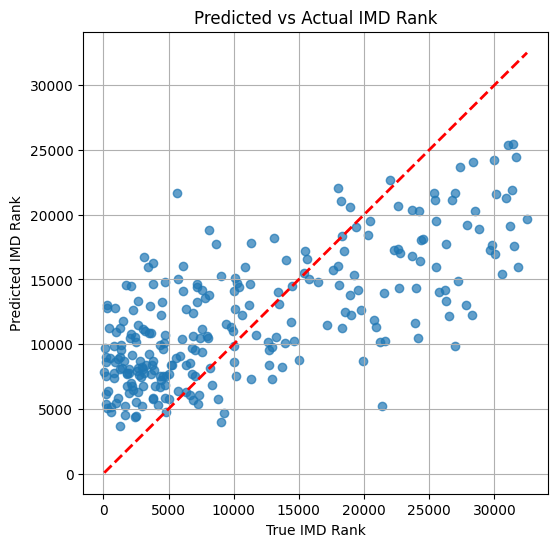

In [62]:
# Expand the embedding vectors into separate columns
embedding_dim = 50
feature_cols = []

X_list = []

for k in range(5):  # cluster_0 to cluster_5
    col_name = f'cluster_{k}'
    # Expand each vector into embedding_dim columns
    cluster_expanded = pd.DataFrame(avg_embeddings_with_imd_gdf[col_name].tolist(),
                                    columns=[f'{col_name}_dim{i}' for i in range(embedding_dim)])
    X_list.append(cluster_expanded)
    feature_cols.extend(cluster_expanded.columns)

# Concatenate all cluster columns
X = pd.concat(X_list, axis=1)

# Target
y = avg_embeddings_with_imd_gdf[var_to_predict]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics = evaluate_imd_model(y_test, y_pred)

# Build model with one embedding per LSOA
### Get data

In [81]:
avg_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa.pkl")
avg_embeddings_with_imd = pd.merge(left=avg_embeddings, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 5843.716
MAE: 4696.391
R2: 0.630
Spearman_rank_corr: 0.763


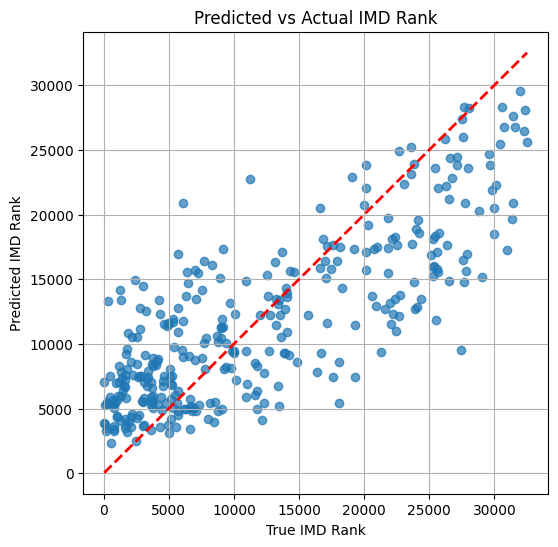

In [80]:
X = np.stack(avg_embeddings_with_imd["embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

# Build model with one embedding per location.

### Get data.

In [85]:
avg_embeddings_per_location = pd.read_pickle(data_dir +"mean_embeddings_per_location.pkl")
avg_embeddings_per_location_with_imd = pd.merge(left=avg_embeddings_per_location, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 8335.419
MAE: 7036.674
R2: 0.292
Spearman_rank_corr: 0.542


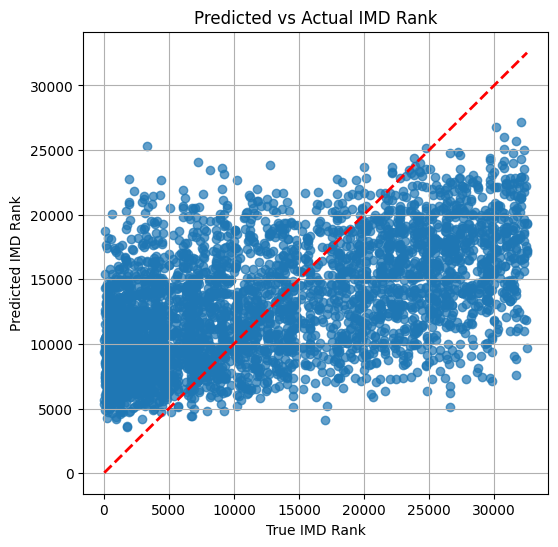

In [88]:
X = np.stack(avg_embeddings_per_location_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_per_location_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)